#### Day 3 – Data Augmentation

In this notebook I implement and test a data augmentation pipeline for the
aerial bird vs drone classification task.

**Goals:**
- Add realistic augmentations: rotation, horizontal flip, zoom, brightness, slight crop.
- Visualize original vs augmented samples.
- Package augmentations into reusable functions that can be plugged into model training.

In [6]:
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

BASE_DIR = Path("../data/classification_dataset")
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

print("Using dataset path:", BASE_DIR.resolve())


Using dataset path: D:\356 Data Science\PROJECT\LABMENTIX\Aerial Object Classification\data\classification_dataset


#### 1. Load and Normalize Datasets

Here I:
- Load images from the `train`, `valid`, and `test` folders.
- Resize them to `(224, 224)`.
- Convert labels to binary (bird/drone).
- Normalize pixel values from `[0, 255]` to `[0, 1]`.


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR / "train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR / "valid",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR / "test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode="binary"
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 2662 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 442 files belonging to 2 classes.
Found 215 files belonging to 2 classes.
Class names: ['bird', 'drone']
Found 215 files belonging to 2 classes.
Class names: ['bird', 'drone']


In [8]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds_norm = (
    train_ds
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .prefetch(AUTOTUNE)
)

val_ds_norm = (
    val_ds
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

test_ds_norm = (
    test_ds
    .map(normalize_img, num_parallel_calls=AUTOTUNE)
    .prefetch(AUTOTUNE)
)

train_ds_norm, val_ds_norm, test_ds_norm


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>)

#### 2. Define Data Augmentation Layer

This layer performs:
- `RandomFlip("horizontal")` – left–right flip.
- `RandomRotation(0.1)` – small random rotations.
- `RandomZoom` – slight zoom in/out.
- Random brightness adjustment.
- Slight random crop followed by resizing back to `(224, 224)`.

It will be used:
- either at the start of the model, or
- applied to batches from the dataset during training.


In [9]:
def get_augmentation_layer(img_size=IMG_SIZE):
    height, width = img_size

    # custom brightness adjustment
    brightness_layer = layers.Lambda(
        lambda x: tf.image.random_brightness(x, max_delta=0.1)
    )

    augmentation = tf.keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(
                height_factor=(-0.1, 0.1),
                width_factor=(-0.1, 0.1),
            ),
            brightness_layer,
            layers.RandomCrop(int(height * 0.9), int(width * 0.9)),
            layers.Resizing(height, width),
        ],
        name="data_augmentation",
    )
    return augmentation

data_augmentation = get_augmentation_layer()
data_augmentation


<Sequential name=data_augmentation, built=False>

#### 3. Visualize Original vs Augmented Samples

Here I:
1. Take one batch from `train_ds_norm`.
2. Show a few original images (top row).
3. Apply the augmentation layer in training mode.
4. Show the augmented images (bottom row).

This helps verify that:
- Augmentations are realistic.
- Shapes remain `(224, 224, 3)`.
- Labels still make sense (bird vs drone).


Batch shape: (32, 224, 224, 3)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09455855..1.0772536].


Augmented batch shape: (32, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.23250028..1.0494212].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12496015..1.0897404].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12496015..1.0897404].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12751..1.085994].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.12751..1.085994].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09014389..1.0595145].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.09014389..1.059

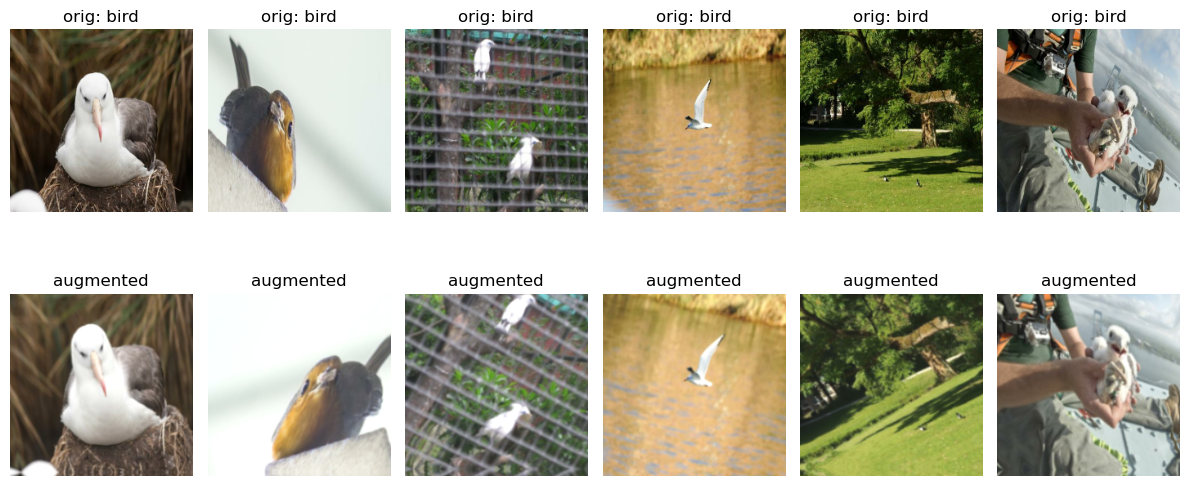

In [10]:
import numpy as np

# grab one batch
for images, labels in train_ds_norm.take(1):
    images_batch = images
    labels_batch = labels
    break

print("Batch shape:", images_batch.shape)

augmented_batch = data_augmentation(images_batch, training=True)
print("Augmented batch shape:", augmented_batch.shape)

num_to_show = 6
plt.figure(figsize=(12, 6))

for i in range(num_to_show):
    # original
    ax = plt.subplot(2, num_to_show, i + 1)
    plt.imshow(images_batch[i].numpy())
    label_idx = int(labels_batch[i].numpy().item())
    plt.title(f"orig: {class_names[label_idx]}")
    plt.axis("off")

    # augmented
    ax = plt.subplot(2, num_to_show, num_to_show + i + 1)
    plt.imshow(augmented_batch[i].numpy())
    plt.title("augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()


#### 4. Wrap Augmentation into a Reusable Function

To make training easier, I wrap augmentation in a helper function:

- Takes a normalized dataset (`train_ds_norm`).
- Applies the `data_augmentation` layer on the fly.
- Returns a new dataset (`train_ds_aug`) ready to feed into the model.

Only the **training** dataset is augmented; validation and test are left unchanged.


In [11]:
def apply_augmentation(dataset, augmentation_layer, autotune=AUTOTUNE):
    """
    Apply the augmentation layer to a tf.data dataset of (images, labels).
    Augmentation is applied in training mode only.
    """
    return (
        dataset
        .map(
            lambda x, y: (augmentation_layer(x, training=True), y),
            num_parallel_calls=autotune,
        )
        .prefetch(autotune)
    )

train_ds_aug = apply_augmentation(train_ds_norm, data_augmentation)
train_ds_aug


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054379486..0.90918654].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05542264..0.9186015].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05542264..0.9186015].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04269775..0.942365].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04269775..0.942365].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024212865..0.942365].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

Augmented train batch shape: (32, 224, 224, 3) (32, 1)


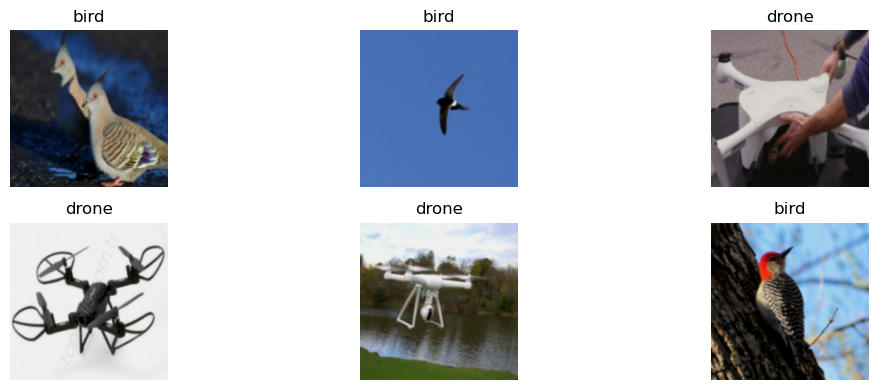

In [12]:
for images, labels in train_ds_aug.take(1):
    print("Augmented train batch shape:", images.shape, labels.shape)

    plt.figure(figsize=(12, 4))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy())
        label_idx = int(labels[i].numpy().item())
        plt.title(class_names[label_idx])
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break


#### 5. Summary

In this notebook I:

- Implemented a `data_augmentation` layer with:
  - random horizontal flips,
  - small random rotations,
  - random zoom,
  - random brightness,
  - slight random crops.
- Visualized original vs augmented samples to check that transformations
  are realistic and images remain usable.
- Packaged augmentations into a reusable `apply_augmentation()` function
  that creates an augmented training dataset (`train_ds_aug`).

This augmented dataset will now be used to train:
- a Custom CNN (Day 4), and
- transfer learning models (later days).
